In [9]:
import os
import pandas as pd
import random
import numpy as np
import cv2
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.transforms import ToTensor
import os
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import segmentation_models_pytorch as smp
from model import model1

In [5]:
import wandb


In [7]:
wandb.login(
    # set the wandb project where this run will be logged
#     project= "PolypSegment", 
    key = "1a67d2cfa6cecdcaa32adf087e1268ca8b09bc26",
)
wandb.init(
    project = "BKAI_IGH"
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nguyenhoangson_hsgs19 (nguyenhoangson_hsgs19-hanoi-university-of-science-and-te). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Admin\_netrc


In [42]:
class Preprocess(Dataset):
    def __init__(self, image_folder, mask_folder=None, target_size=None, has_labels=True):
        self.image_folder = image_folder

        self.mask_folder = mask_folder
        self.target_size = target_size
        self.has_labels = has_labels
        self.image_filenames = os.listdir(self.image_folder)

    def __len__(self):
        return len(self.image_filenames)

    def process_mask(self, mask_path):
        mask = cv2.imread(mask_path)
        if self.target_size:
            mask = cv2.resize(mask, self.target_size)
            mask_hsv = cv2.cvtColor(mask, cv2.COLOR_BGR2HSV)

            red_lower1, red_upper1 = np.array([0, 100, 20]), np.array([10, 255, 255])
            red_lower2, red_upper2 = np.array([160, 100, 20]), np.array([179, 255, 255])

            red_part1 = cv2.inRange(mask_hsv, red_lower1, red_upper1)
            red_part2 = cv2.inRange(mask_hsv, red_lower2, red_upper2)
            red_mask = red_part1 + red_part2
            red_mask[red_mask > 0] = 1

            green_lower, green_upper = np.array([36, 25, 25]), np.array([70, 255, 255])
            green_mask = cv2.inRange(mask_hsv, green_lower, green_upper)
            green_mask[green_mask > 0] = 2

            combined_mask = np.maximum(red_mask, green_mask)
            combined_mask = np.expand_dims(combined_mask, axis=-1).astype(np.uint8)
            return combined_mask


    def __getitem__(self, index):
        image_path = os.path.join(self.image_folder, self.image_filenames[index])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.target_size:
            image = cv2.resize(image, self.target_size)

        if self.has_labels:
            mask_path = os.path.join(self.mask_folder, self.image_filenames[index])
            mask = self.process_mask(mask_path)
            return image, mask
        else:
            return image



In [43]:
train_path = "data/train/train/"
train_gt_path = 'data/train_gt/train_gt'
test_path = "data/test/test"
batch_size = 10
learning_rate = 0.0001
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
best = 10000
origin_epochs = 50 # for base model


In [44]:
import segmentation_models_pytorch as smp
dataset = Preprocess(train_path,train_gt_path,(256,256))
test = Preprocess(image_folder=test_path,target_size=(256, 256),has_labels=False)
from model import model1
model = model1

In [20]:
project = "BKAI_IGH"
resume = "allow"
num_epochs = 10  # to test
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
wandb.init(
    project=project,
    resume= resume,
    config={
        "learning_rate": learning_rate,
        "epochs": num_epochs,
        "batch_size": batch_size,
    },
    name=f"model1_lr_{learning_rate}"
)

In [24]:
wandb.finish()

train_loss,█▁
valid_loss,█▁
train_loss,3.04222
valid_loss,1.00389


In [26]:
wandb.watch(model)

In [15]:
train_size = 0.8
val_size = 0.2
torch.manual_seed(123)

In [16]:
images_data = []
labels_data = []

for image,label in dataset:
    images_data.append(image)
    labels_data.append(label)


In [68]:

class UNetDataset(Dataset):
    def __init__(self, data, targets=None, has_targets=True):
        self.data = data
        self.targets = targets
        self.has_targets = has_targets
        self.transform = A.Compose([
            A.RGBShift(p=0.3, r_shift_limit=15, g_shift_limit=15, b_shift_limit=15),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

    def __getitem__(self, index):
        image = self.data[index]
        if self.has_targets:
            label = self.targets[index]
            assert image.shape[:2] == label.shape[:2]
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
            return image, label
        else:
            transformed = self.transform(image=image)
            image = transformed['image'].float()
            return image

    def __len__(self):
        return len(self.data)

In [45]:
train_set, valid_set = random_split(UNetDataset(images_data, labels_data),
                                    [int(train_size * len(images_data)) , 
                                     int(val_size * len(images_data))])
test_set = UNetDataset(test,has_targets=False)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [67]:
print(type(test_set))

<class '__main__.UNetDataset'>


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
# base checkpoint
model.to(device)
epoch_bar = tqdm(total=origin_epochs, desc='Total Progress')
for epoch in range(origin_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1).long()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()
            outputs = model(images)
            val_loss += criterion(outputs.float(),labels.long()).item()
    print(f"Epoch [{epoch+1}/{origin_epochs}], Loss: {val_loss/len(val_loader):.10f}")
    if val_loss < best:
        best = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        save_path = f'model.pth'
        torch.save(checkpoint, save_path)
        
    epoch_bar.update(1)
epoch_bar.close()

Total Progress:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.4592715752


Total Progress:   2%|▏         | 1/50 [01:36<1:18:37, 96.28s/it]

Epoch [2/50], Loss: 0.2392044294


Total Progress:   4%|▍         | 2/50 [02:48<1:05:46, 82.22s/it]

Epoch [3/50], Loss: 0.1500769261


Total Progress:   6%|▌         | 3/50 [04:00<1:00:46, 77.58s/it]

Epoch [4/50], Loss: 0.1161187190


Total Progress:   8%|▊         | 4/50 [05:17<59:15, 77.29s/it]  

Epoch [5/50], Loss: 0.0948189777


Total Progress:  10%|█         | 5/50 [06:37<58:34, 78.10s/it]

Epoch [6/50], Loss: 0.0782490022


Total Progress:  12%|█▏        | 6/50 [07:57<57:56, 79.02s/it]

Epoch [7/50], Loss: 0.0712339446


Total Progress:  14%|█▍        | 7/50 [09:20<57:31, 80.26s/it]

Epoch [8/50], Loss: 0.0646783194


Total Progress:  16%|█▌        | 8/50 [10:45<57:06, 81.59s/it]

Epoch [9/50], Loss: 0.0597096242


Total Progress:  18%|█▊        | 9/50 [12:11<56:44, 83.04s/it]

Epoch [10/50], Loss: 0.0563038148


Total Progress:  20%|██        | 10/50 [13:39<56:19, 84.49s/it]

Epoch [11/50], Loss: 0.0553003232


Total Progress:  22%|██▏       | 11/50 [15:07<55:40, 85.66s/it]

Epoch [12/50], Loss: 0.0506255277


Total Progress:  24%|██▍       | 12/50 [16:39<55:23, 87.46s/it]

Epoch [13/50], Loss: 0.0482185133


Total Progress:  28%|██▊       | 14/50 [19:49<54:53, 91.49s/it]

Epoch [14/50], Loss: 0.0516066007


Total Progress:  30%|███       | 15/50 [21:25<54:15, 93.00s/it]

Epoch [15/50], Loss: 0.0504061826
Epoch [16/50], Loss: 0.0445257197


Total Progress:  32%|███▏      | 16/50 [23:02<53:20, 94.14s/it]

Epoch [17/50], Loss: 0.0421533433


Total Progress:  36%|███▌      | 18/50 [26:09<49:58, 93.70s/it]

Epoch [18/50], Loss: 0.0573275349


Total Progress:  38%|███▊      | 19/50 [27:39<47:46, 92.45s/it]

Epoch [19/50], Loss: 0.0443570123


Total Progress:  40%|████      | 20/50 [29:09<45:58, 91.95s/it]

Epoch [20/50], Loss: 0.0451665026


Total Progress:  42%|████▏     | 21/50 [30:41<44:19, 91.72s/it]

Epoch [21/50], Loss: 0.0428101729


Total Progress:  44%|████▍     | 22/50 [32:09<42:20, 90.74s/it]

Epoch [22/50], Loss: 0.0458516754
Epoch [23/50], Loss: 0.0382578683


Total Progress:  48%|████▊     | 24/50 [35:02<38:19, 88.44s/it]

Epoch [24/50], Loss: 0.0418610124


Total Progress:  50%|█████     | 25/50 [36:24<36:03, 86.54s/it]

Epoch [25/50], Loss: 0.0494171143


Total Progress:  52%|█████▏    | 26/50 [37:41<33:31, 83.82s/it]

Epoch [26/50], Loss: 0.0560352839


Total Progress:  54%|█████▍    | 27/50 [39:00<31:31, 82.25s/it]

Epoch [27/50], Loss: 0.0493381560


Total Progress:  56%|█████▌    | 28/50 [40:15<29:26, 80.29s/it]

Epoch [28/50], Loss: 0.0472171302


Total Progress:  58%|█████▊    | 29/50 [41:31<27:38, 78.98s/it]

Epoch [29/50], Loss: 0.0462878146


Total Progress:  60%|██████    | 30/50 [42:47<26:01, 78.07s/it]

Epoch [30/50], Loss: 0.0498634457


Total Progress:  62%|██████▏   | 31/50 [44:05<24:42, 78.00s/it]

Epoch [31/50], Loss: 0.0430582928


Total Progress:  64%|██████▍   | 32/50 [45:21<23:09, 77.20s/it]

Epoch [32/50], Loss: 0.0446898982


Total Progress:  66%|██████▌   | 33/50 [46:36<21:43, 76.70s/it]

Epoch [33/50], Loss: 0.0414499033


Total Progress:  68%|██████▊   | 34/50 [47:52<20:21, 76.34s/it]

Epoch [34/50], Loss: 0.0497866977


Total Progress:  70%|███████   | 35/50 [49:07<19:00, 76.05s/it]

Epoch [35/50], Loss: 0.0443241079


Total Progress:  72%|███████▏  | 36/50 [50:24<17:48, 76.30s/it]

Epoch [36/50], Loss: 0.0419405570


Total Progress:  74%|███████▍  | 37/50 [51:40<16:31, 76.25s/it]

Epoch [37/50], Loss: 0.0483090650


Total Progress:  76%|███████▌  | 38/50 [52:57<15:17, 76.50s/it]

Epoch [38/50], Loss: 0.0514629205


Total Progress:  78%|███████▊  | 39/50 [54:15<14:04, 76.81s/it]

Epoch [39/50], Loss: 0.0512975245


Total Progress:  80%|████████  | 40/50 [55:30<12:43, 76.32s/it]

Epoch [40/50], Loss: 0.0494099645


Total Progress:  82%|████████▏ | 41/50 [56:46<11:26, 76.25s/it]

Epoch [41/50], Loss: 0.0636770648


Total Progress:  84%|████████▍ | 42/50 [58:03<10:13, 76.65s/it]

Epoch [42/50], Loss: 0.0432557013


Total Progress:  86%|████████▌ | 43/50 [59:18<08:52, 76.11s/it]

Epoch [43/50], Loss: 0.0484324574


Total Progress:  88%|████████▊ | 44/50 [1:00:34<07:35, 75.95s/it]

Epoch [44/50], Loss: 0.0445578384


Total Progress:  90%|█████████ | 45/50 [1:01:51<06:21, 76.34s/it]

Epoch [45/50], Loss: 0.0510036216


Total Progress:  92%|█████████▏| 46/50 [1:03:07<05:04, 76.20s/it]

Epoch [46/50], Loss: 0.0497159549


Total Progress:  94%|█████████▍| 47/50 [1:04:25<03:50, 76.75s/it]

Epoch [47/50], Loss: 0.0506285137


Total Progress:  96%|█████████▌| 48/50 [1:05:43<02:34, 77.04s/it]

Epoch [48/50], Loss: 0.0508034969


Total Progress:  98%|█████████▊| 49/50 [1:06:57<01:16, 76.07s/it]

Epoch [49/50], Loss: 0.0514693623


Total Progress: 100%|██████████| 50/50 [1:08:14<00:00, 81.89s/it]

Epoch [50/50], Loss: 0.0473644343


In [28]:
checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [27]:

save_path = 'model.pth'
checkpoint = torch.load(save_path)
model.to(device)
model.load_state_dict(checkpoint['model'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer'])
start_epoch = checkpoint['epoch'] + 1
best = checkpoint['loss']
criterion = nn.CrossEntropyLoss()
epoch_bar = tqdm(total=num_epochs, desc='Total Progress')
for epoch in range(start_epoch, start_epoch + num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(dim=1).long()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(dim=1).long()
            outputs = model(images)
            val_loss += criterion(outputs.float(),labels.long()).item()

    print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Loss: {val_loss/len(val_loader):.10f}")

    if val_loss < best:
        best = val_loss
        checkpoint = { 
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': val_loss,
        }
        torch.save(checkpoint, save_path)
    epoch_bar.update(1) 
    wandb.log({'valid_loss': val_loss/len(val_loader),'train_loss': train_loss/len(train_loader)})
    
epoch_bar.close()
wandb.finish()

Total Progress:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\Admin\PycharmProjects\Object_Detection\.venv\lib\site-packages\wandb\sdk\wandb_run.py:2386: UserWarning: Run (6wuauu5j) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
Total Progress:  20%|██        | 2/10 [05:26<21:46, 163.35s/it]


Epoch [5/14], Loss: 0.0463858401


Total Progress:  10%|█         | 1/10 [02:28<22:13, 148.16s/it]

Epoch [6/14], Loss: 0.0562763692


Total Progress:  20%|██        | 2/10 [04:30<17:43, 132.91s/it]

Epoch [7/14], Loss: 0.0470087530


Total Progress:  30%|███       | 3/10 [06:36<15:09, 129.95s/it]

Epoch [8/14], Loss: 0.0469231246


Total Progress:  40%|████      | 4/10 [08:47<13:01, 130.24s/it]

Epoch [9/14], Loss: 0.0546313106


Total Progress:  50%|█████     | 5/10 [11:01<10:58, 131.60s/it]

Epoch [10/14], Loss: 0.0407756526


Total Progress:  60%|██████    | 6/10 [13:11<08:43, 130.99s/it]

Epoch [11/14], Loss: 0.0502502297


Total Progress:  70%|███████   | 7/10 [15:24<06:35, 131.80s/it]

Epoch [12/14], Loss: 0.0508996531


Total Progress:  80%|████████  | 8/10 [17:29<04:18, 129.45s/it]

Epoch [13/14], Loss: 0.0400891146


Total Progress:  90%|█████████ | 9/10 [19:32<02:07, 127.61s/it]

Epoch [14/14], Loss: 0.0409164943


Total Progress: 100%|██████████| 10/10 [21:40<00:00, 130.06s/it]


train_loss,█▇▆▇▅▄▃▃▃▁
valid_loss,▄█▄▄▇▁▅▆▁▁
train_loss,1.37638
valid_loss,0.81833


In [64]:
checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['model'])


<All keys matched successfully>

In [28]:
print(len(val_loader))
print(len(train_loader))

20
80


In [65]:
normalize = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [66]:
model.eval()
for filename in os.listdir(test_path):
    img_path = os.path.join(test_path, filename)
    restore_img = cv2.imread(img_path)
    restore_img = cv2.cvtColor(restore_img, cv2.COLOR_BGR2RGB)
    transform = normalize(cv2.resize(restore_img, (256, 256)))
    input = transform["image"].unsqueeze(0).to(device)
    with torch.no_grad():
        output = model.forward(input).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output, (restore_img.shape[1], restore_img.shape[0]))
    mask = np.argmax(mask, axis=2)
    mask_rgb = np.uint8(np.stack([np.where(mask == k, color_dict[k][i], 0) for i in range(3) for k in color_dict.keys()], axis=-1).reshape(mask.shape[0], mask.shape[1], 3).sum(axis=2))
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(filename), mask_rgb) 

KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'

In [34]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = 'prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'submission2.csv', index=False)

prediction\019410b1fcf0625f608b4ce97629ab55.jpeg
prediction\02fa602bb3c7abacdbd7e6afd56ea7bc.jpeg
prediction\0398846f67b5df7cdf3f33c3ca4d5060.jpeg
prediction\05734fbeedd0f9da760db74a29abdb04.jpeg
prediction\05b78a91391adc0bb223c4eaf3372eae.jpeg
prediction\0619ebebe9e9c9d00a4262b4fe4a5a95.jpeg
prediction\0626ab4ec3d46e602b296cc5cfd263f1.jpeg
prediction\0a0317371a966bf4b3466463a3c64db1.jpeg
prediction\0a5f3601ad4f13ccf1f4b331a412fc44.jpeg
prediction\0af3feff05dec1eb3a70b145a7d8d3b6.jpeg
prediction\0fca6a4248a41e8db8b4ed633b456aaa.jpeg
prediction\1002ec4a1fe748f3085f1ce88cbdf366.jpeg
prediction\1209db6dcdda5cc8a788edaeb6aa460a.jpeg
prediction\13dd311a65d2b46d0a6085835c525af6.jpeg
prediction\1531871f2fd85a04faeeb2b535797395.jpeg
prediction\15fc656702fa602bb3c7abacdbd7e6af.jpeg
prediction\1ad4f13ccf1f4b331a412fc44655fb51.jpeg
prediction\1b62f15ec83b97bb11e8e0c4416c1931.jpeg
prediction\1c0e9082ea2c193ac8d551c149b60f29.jpeg
prediction\1db239dda50f954ba59c7de13a35276a.jpeg
prediction\26679bff5

In [ ]:
wandb.finish()

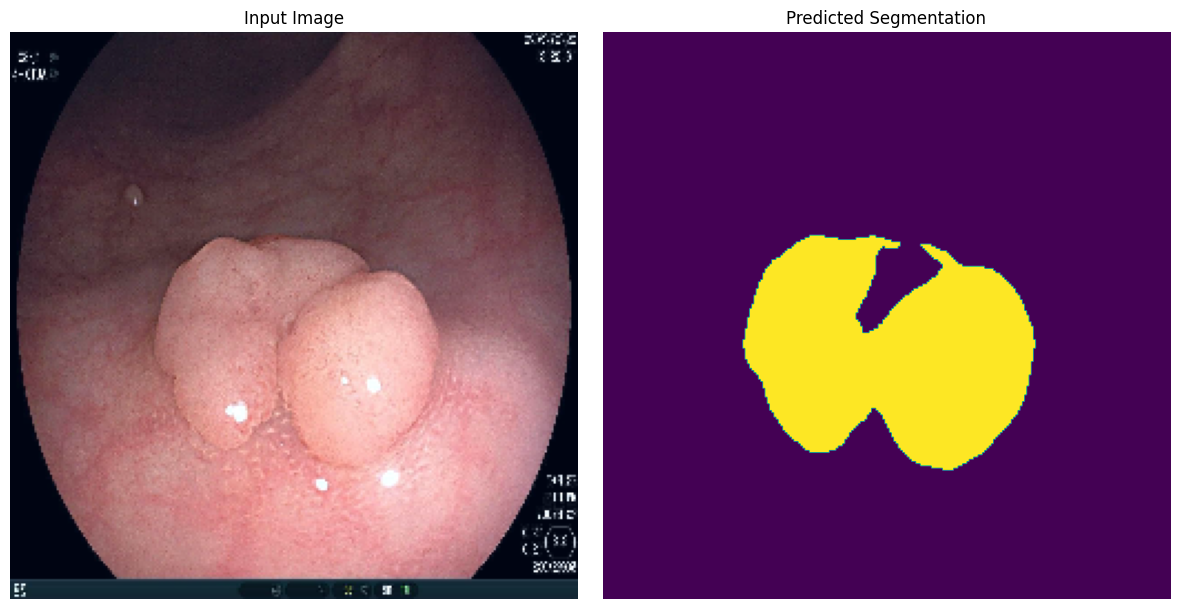

In [63]:
import matplotlib.pyplot as plt
import numpy as np

image= next(iter(test_loader))
images = image.to(device)
model.to(device)
save_path = 'model.pth'
checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model'])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer'])
criterion = nn.CrossEntropyLoss()
model.eval()

with torch.no_grad():
    outputs = model(images)

predictions = torch.argmax(outputs, dim=1)
predict = predictions[0].cpu().numpy() 
input_image = images[0].cpu().permute(1, 2, 0).numpy()

input_image = np.clip((input_image * 0.229) + 0.485, 0, 1)  

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predict, cmap="viridis")  # Sử dụng cmap để phân biệt các lớp
plt.title("Predicted Segmentation")
plt.axis("off")

plt.tight_layout()
plt.show()
